## 0. Goal 
Run PCA on the VAE latent features, instead of UMAP

In [7]:
import os, sys, importlib, librosa, glob, h5py, tqdm, pickle
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from joblib import Parallel, delayed
import random
import umap, hdbscan
from collections import Counter, OrderedDict
import seaborn as sns
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from skimage import transform
import gc
import colorsys
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA


plt.rcParams['pdf.fonttype'] = 42 

In [2]:
# import my utility script
cluster_script_path = '/home/zz367/ProjectsU/EphysMONAO/Jupyter/MatlabCodes/ZZ_callClustering/'
sys.path.insert(1, cluster_script_path)
import vae_goffinet, hopkins
importlib.reload(vae_goffinet)

<module 'vae_goffinet' from '/home/zz367/ProjectsU/EphysMONAO/Jupyter/MatlabCodes/ZZ_callClustering/vae_goffinet.py'>

In [3]:
# create a custom colormap for spectrogram
jet = plt.get_cmap('jet', 255)
# Extract jet colors and prepend black at the beginning
jet_colors = jet(np.linspace(0, 1, 255))
custom_colors = np.vstack([[0, 0, 0, 1], jet_colors])  # Black for 0, then jet
custom_cmap = ListedColormap(custom_colors)

## 1. Inputs

In [4]:
fd_z4 = '/mnt/z4'
fd_data = os.path.join(fd_z4, 'zz367', 'EphysMONAO', 'Analyzed', 'vaeWav')
birdID = 'pair5RigCCU29'
# color limits when calculating spectrograms, depending on the audio amplitude, may differ between birds
clims = [1.5,7]
# what syllable pairs to analyze
v_all = ['v4', 'v5']
# what spectogram datasets to use
spec_suffix = 'Spectrogram1'
spec_run = 'spec_goffinet_traj_256_236'
# what VAE run to use
vae_suffix = 'VAE1'
vae_run = 'traj_chop_32_2_32'
fd_vae = os.path.join(fd_data, birdID, 'Traj', vae_suffix, vae_run)
# where the VAE latents results are saved
apply_suffix = 'applySyl1'
apply_run = f'latent.{vae_run}'
fd_latent = os.path.join(fd_data, birdID, 'Traj', apply_suffix, apply_run)
print(fd_latent)

/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5RigCCU29/Traj/applySyl1/latent.traj_chop_32_2_32


In [5]:
# where to save results
fd_save = os.path.join(fd_data, birdID, 'Traj', apply_suffix, 'paramSearch1')
if not os.path.exists(fd_save):
    os.makedirs(fd_save)
print(fd_save)

/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5RigCCU29/Traj/applySyl1/paramSearch1


In [6]:
# load the latent
syl_str = ''.join(v_all)
fn_latent = os.path.join(fd_save, f'{syl_str}_latent_comb.csv')
latent_comb = np.loadtxt(fn_latent)
fn_info = os.path.join(fd_save, f'{syl_str}_info_comb.csv')
info_comb = pd.read_csv(fn_info, index_col=0)
print(latent_comb.shape, info_comb.shape)

(61152, 32) (61152, 21)


## 2. Run PCA

In [23]:
# standardize the latent features
d = latent_comb.copy()
scaler = StandardScaler(with_mean=True, with_std=True)
d = scaler.fit_transform(d)     # same shape as d

In [24]:
pca = PCA()
latent_pca = pca.fit_transform(d)

# Output
print("Shape of projections:", latent_pca.shape)
print("Explained variance ratio:", pca.explained_variance_ratio_)

Shape of projections: (61152, 32)
Explained variance ratio: [2.21080560e-01 1.65816837e-01 1.29666970e-01 9.05061087e-02
 7.28895286e-02 6.43494849e-02 6.20110931e-02 5.29029328e-02
 4.47954688e-02 3.24471343e-02 2.46241391e-02 9.29388216e-03
 6.16668692e-03 4.69141831e-03 4.39829065e-03 3.93061577e-03
 2.90870160e-03 1.77099948e-03 1.62963054e-03 1.16872022e-03
 9.24817413e-04 7.55402844e-04 4.86861343e-04 3.54852553e-04
 1.71541001e-04 1.19084131e-04 9.44950708e-05 3.28951849e-05
 1.08480651e-05 4.09397723e-16 3.56849362e-16 2.47867532e-16]


Text(0, 0.5, 'Proporition of variance explained')

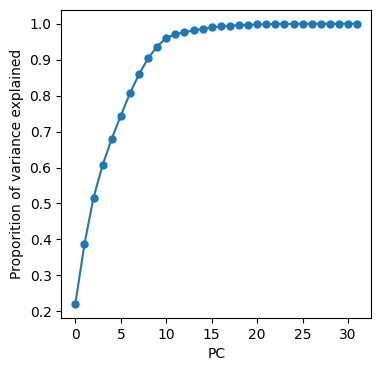

In [25]:
# plot proportion of variance explained
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[4, 4])
var_cumsum = np.cumsum(pca.explained_variance_ratio_)
ax.plot(np.arange(var_cumsum.shape[0]), var_cumsum, marker='o', markersize=5)
ax.set_xlabel('PC')
ax.set_ylabel('Proporition of variance explained')

#### plot the first two PCs

In [26]:
# put results in a master dataframe
embed = info_comb.copy()
for ii in range(latent_comb.shape[1]):
    embed[f'vae{ii}'] = latent_comb[:,ii]
for jj in range(latent_pca.shape[1]):
    embed[f'pca{jj+1}'] = latent_pca[:,jj]

Text(0, 0.5, 'PCA axis 2')

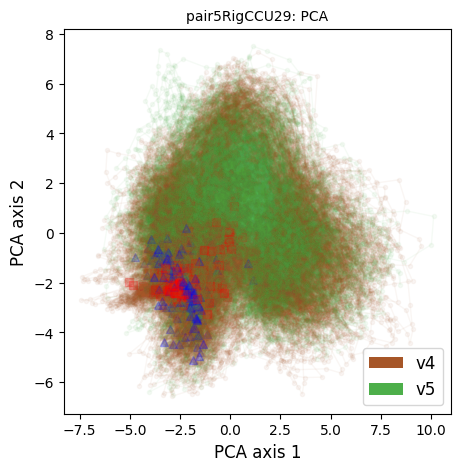

In [29]:
#### plot results, different color for different call subtypes
col_full = ['#a65628','#4daf4a','#984ea3','#e41a1c','#ff7f00','#f781bf','#377eb8','#737373']
col_dict = OrderedDict(zip(v_all, col_full[0:len(v_all)]))
# get the syl id
syl_comb = list(set(info_comb['syl_id']))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[5, 5])
for si in range(len(syl_comb)):
    ss = syl_comb[si]
    embed_s = embed[embed['syl_id']==ss]
    embed_s.index = range(embed_s.shape[0])
    x = np.array(embed_s['pca1'])
    y = np.array(embed_s['pca2'])
    v = embed_s['call_subtype'][0]
    ax.plot(x, y,  marker='o', linestyle='-', color=col_dict[v], markersize=3, linewidth=1, alpha=0.05)
    # mark the start with triangle, and end with square
    ax.plot(x[0], y[0], marker='^', markersize=6, color='blue', alpha=0.25)
    ax.plot(x[-1], y[-1], marker='s', markersize=6, color='red', alpha=0.25)
# add legend
legends = [Patch(facecolor=col_dict[name], label=name) for name in col_dict.keys()]
ax.legend(handles=legends, loc='lower right', fontsize=12)
ax.set_title(f'{birdID}: PCA', fontsize=10)
ax.set_xlabel('PCA axis 1', fontsize=12)
ax.set_ylabel('PCA axis 2', fontsize=12)